# Model

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,StratifiedKFold

from keras.optimizer_v2 import adam
from tensorflow.keras import initializers
from tensorflow.keras.constraints import max_norm

seed = 7
np.random.seed(seed)

# Binary (without multilabel)

In [ ]:
#Read the data
train_df = pd.read_csv('processed_data.csv')
train_df.head(5)

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_token,is_toxic
0,0,0000997932d777bf,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0,"['explan', 'edit', 'made', 'usernam', 'hardcor...",0
1,1,000103f0d9cfb60f,aww match background colour seem stuck thank t...,0,0,0,0,0,0,"['aww', 'match', 'background', 'colour', 'seem...",0
2,2,000113f07ec002fd,hey man realli tri edit war guy constant remov...,0,0,0,0,0,0,"['hey', 'man', 'realli', 'tri', 'edit', 'war',...",0
3,3,0001b41b1c6bb37e,cannot make real suggest improv wonder section...,0,0,0,0,0,0,"['cannot', 'make', 'real', 'suggest', 'improv'...",0
4,4,0001d958c54c6e35,sir hero chanc rememb,0,0,0,0,0,0,"['sir', 'hero', 'chanc', 'rememb']",0


In [ ]:
X,y = train_df.comment_text, train_df.is_toxic
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45, stratify=y)
(train_df.is_toxic.value_counts() / train_df.shape[0]) * 100

0    89.832112
1    10.167888
Name: is_toxic, dtype: float64

In [ ]:
#Tfidf 
vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2), max_features= 2000,strip_accents='unicode', norm='l2')
X_train = vectorizer.fit_transform(X_train.values.astype('U')).todense()
X_test = vectorizer.transform(X_test.values.astype('U')).todense()
#To numpy
X_train = np.squeeze(np.asarray(X_train))
y_train = y_train.values

class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight(class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train.values.reshape(-1)))) 
class_weights

{0: 0.5565942307021522, 1: 4.917411402157165}

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.1,
                              patience=8, min_lr=1e-10,verbose = 1)

custom_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', mode='min', verbose=1, patience=20
)

num_folds = 5

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=num_folds)
kfold.get_n_splits(X_train, y_train)
# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []

METRICS = [ 
      tf.keras.metrics.AUC(name='auc'),
]

In [ ]:
max_n = 4.
d1 = 0.1
d2 = 0.0

def create_model(learn_rate):
    
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(15, activation=tf.nn.relu, kernel_initializer = initializers.he_normal,bias_initializer=initializers.he_normal, input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(d1),
        tf.keras.layers.BatchNormalization(),
        
    tf.keras.layers.Dense(10, activation=tf.nn.relu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        tf.keras.layers.Dropout(d2),
        tf.keras.layers.BatchNormalization(),
        
    tf.keras.layers.Dense(5, activation=tf.nn.relu, kernel_constraint=max_norm(max_n), kernel_initializer = initializers.he_normal),
        tf.keras.layers.Dropout(d2),
        tf.keras.layers.BatchNormalization(),
        
    tf.keras.layers.Dense(1, activation=  'sigmoid')
 ])
    optimizer = adam.Adam(learning_rate=learn_rate)

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=METRICS)

    return model

model = create_model(0.0001)
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 15)                30015     
                                                                 
 dropout_15 (Dropout)        (None, 15)                0         
                                                                 
 batch_normalization_15 (Bat  (None, 15)               60        
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 10)                160       
                                                                 
 dropout_16 (Dropout)        (None, 10)                0         
                                                                 
 batch_normalization_16 (Bat  (None, 10)               40        
 chNormalization)                                     

C:\Users\santy\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 0.5565947242206235, 1: 4.9173728813559325}
-----------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/150
1596/1596 [==============================] - 16s 7ms/step - loss: 0.7808 - auc: 0.7551 - val_loss: 0.5115 - val_auc: 0.8099 - lr: 1.0000e-04
Epoch 2/150
1596/1596 [==============================] - 7s 5ms/step - loss: 0.4980 - auc: 0.8419 - val_loss: 0.4316 - val_auc: 0.8785 - lr: 1.0000e-04
Epoch 3/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.4154 - auc: 0.8929 - val_loss: 0.3586 - val_auc: 0.9083 - lr: 1.0000e-04
Epoch 4/150
1596/1596 [==============================] - 8s 5ms/step - loss: 0.3633 - auc: 0.9200 - val_loss: 0.3370 - val_auc: 0.9242 - lr: 1.0000e-04
Epoch 5/150
1596/1596 [==============================] - 10s 6ms/step - loss: 0.3296 - auc: 0.9347 - val_loss: 0.3187 - val_auc: 0.9312 - lr: 1.0000e-04
Epoch 6/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.3076 - auc: 0.94

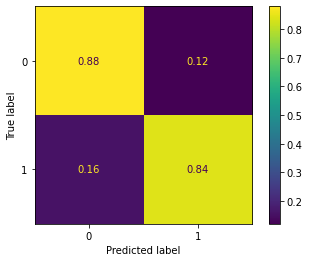

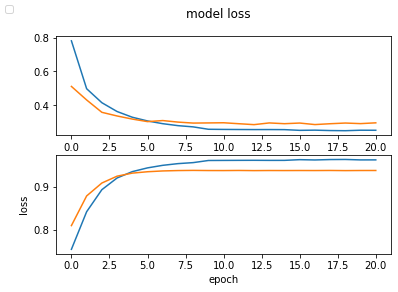

C:\Users\santy\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 0.5565941073238792, 1: 4.917421032357473}
-----------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/150
1596/1596 [==============================] - 9s 6ms/step - loss: 0.2765 - auc: 0.9533 - val_loss: 0.2534 - val_auc: 0.9749 - lr: 1.0000e-06
Epoch 2/150
1596/1596 [==============================] - 11s 7ms/step - loss: 0.2732 - auc: 0.9544 - val_loss: 0.2473 - val_auc: 0.9746 - lr: 1.0000e-06
Epoch 3/150
1596/1596 [==============================] - 13s 8ms/step - loss: 0.2770 - auc: 0.9530 - val_loss: 0.2507 - val_auc: 0.9747 - lr: 1.0000e-06
Epoch 4/150
1596/1596 [==============================] - 13s 8ms/step - loss: 0.2743 - auc: 0.9541 - val_loss: 0.2491 - val_auc: 0.9749 - lr: 1.0000e-06
Epoch 5/150
1596/1596 [==============================] - 12s 7ms/step - loss: 0.2751 - auc: 0.9538 - val_loss: 0.2477 - val_auc: 0.9747 - lr: 1.0000e-06
Epoch 6/150
1596/1596 [==============================] - 12s 7ms/step - loss: 0.2747 - auc: 0.

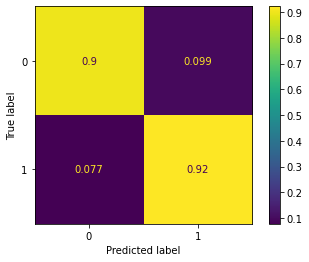

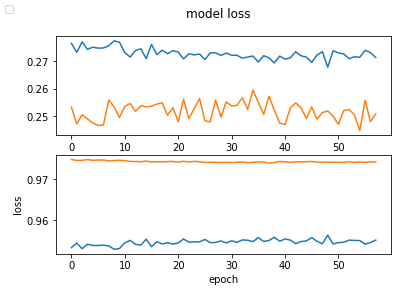

C:\Users\santy\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 0.5565941073238792, 1: 4.917421032357473}
-----------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2701 - auc: 0.9554 - val_loss: 0.2547 - val_auc: 0.9729 - lr: 1.0000e-10
Epoch 2/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2709 - auc: 0.9551 - val_loss: 0.2514 - val_auc: 0.9729 - lr: 1.0000e-10
Epoch 3/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2714 - auc: 0.9551 - val_loss: 0.2531 - val_auc: 0.9730 - lr: 1.0000e-10
Epoch 4/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2711 - auc: 0.9551 - val_loss: 0.2601 - val_auc: 0.9730 - lr: 1.0000e-10
Epoch 5/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2693 - auc: 0.9558 - val_loss: 0.2509 - val_auc: 0.9730 - lr: 1.0000e-10
Epoch 6/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2718 - auc: 0.9549 

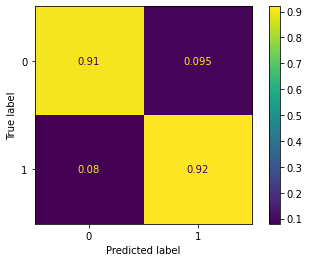

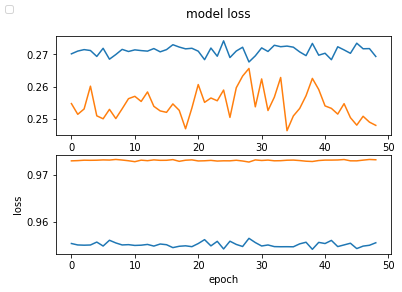

C:\Users\santy\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 0.5565941073238792, 1: 4.917421032357473}
-----------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/150
1596/1596 [==============================] - 8s 5ms/step - loss: 0.2709 - auc: 0.9552 - val_loss: 0.2674 - val_auc: 0.9724 - lr: 1.0000e-10
Epoch 2/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2712 - auc: 0.9551 - val_loss: 0.2593 - val_auc: 0.9723 - lr: 1.0000e-10
Epoch 3/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2713 - auc: 0.9552 - val_loss: 0.2557 - val_auc: 0.9723 - lr: 1.0000e-10
Epoch 4/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2719 - auc: 0.9550 - val_loss: 0.2565 - val_auc: 0.9723 - lr: 1.0000e-10
Epoch 5/150
1596/1596 [==============================] - 5s 3ms/step - loss: 0.2694 - auc: 0.9557 - val_loss: 0.2589 - val_auc: 0.9724 - lr: 1.0000e-10
Epoch 6/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2727 - auc: 0.9545 

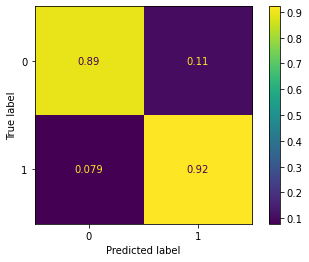

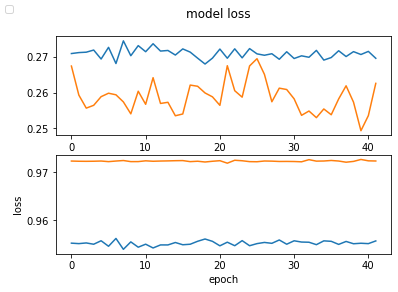

C:\Users\santy\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 0.5565941073238792, 1: 4.917421032357473}
-----------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2721 - auc: 0.9548 - val_loss: 0.2561 - val_auc: 0.9729 - lr: 1.0000e-10
Epoch 2/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2718 - auc: 0.9548 - val_loss: 0.2582 - val_auc: 0.9729 - lr: 1.0000e-10
Epoch 3/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2709 - auc: 0.9553 - val_loss: 0.2585 - val_auc: 0.9728 - lr: 1.0000e-10
Epoch 4/150
1596/1596 [==============================] - 5s 3ms/step - loss: 0.2705 - auc: 0.9553 - val_loss: 0.2612 - val_auc: 0.9725 - lr: 1.0000e-10
Epoch 5/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2686 - auc: 0.9559 - val_loss: 0.2504 - val_auc: 0.9729 - lr: 1.0000e-10
Epoch 6/150
1596/1596 [==============================] - 6s 4ms/step - loss: 0.2692 - auc: 0.9560 

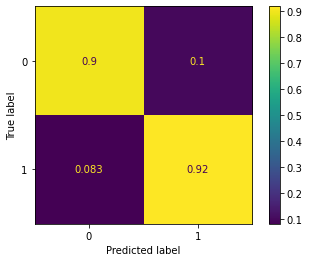

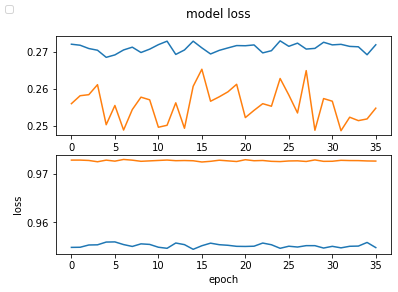

In [ ]:
fold_no = 1
for train, test in kfold.split(X_train, y_train):
    # Compile the model
    
    class_weights = dict(zip(np.unique(y_train[train]), class_weight.compute_class_weight('balanced', np.unique(y_train[train]),y_train[train]))) 
    
    print(class_weights)
      # Generate a print
    print('-----------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model , class_weight=class_weight
    history = model.fit(X_train[train], y_train[train], class_weight=class_weights, validation_data=(X_train[test], y_train[test]),batch_size=64, epochs=150,callbacks=[custom_early_stopping, reduce_lr])

    y_1 = model.predict(X_train[test])
    y_1 = np.round(y_1)
    cm = metrics.confusion_matrix(y_train[test], y_1, normalize='true')
    cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
    
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fig, axs = plt.subplots(2)
    fig.suptitle('model loss')
    fig.legend(['train', 'val'], loc='upper left')

    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[1].plot(history.history['auc'])
    axs[1].plot(history.history['val_auc'])

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

      # Increase fold number
    fold_no = fold_no + 1

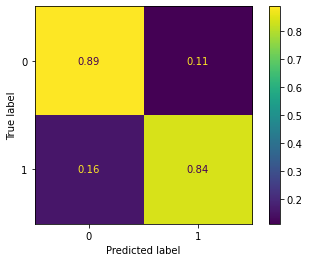

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
clases = ['No toxic', 'Toxic']
pd.DataFrame(y_pred).value_counts()
cm_display = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred, normalize='true')).plot()

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import roc_auc_score
print(classification_report_imbalanced(y_test, y_pred))
print('BACC = '+str(balanced_accuracy_score(y_test,y_pred)))
print('ROC AUC: %.3f' % roc_auc_score(y_test, y_pred,multi_class='ovr'))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.89      0.84      0.93      0.86      0.75     28670
          1       0.46      0.84      0.89      0.59      0.86      0.74      3245

avg / total       0.93      0.88      0.85      0.90      0.86      0.75     31915

BACC = 0.8643339300676149
ROC AUC: 0.864


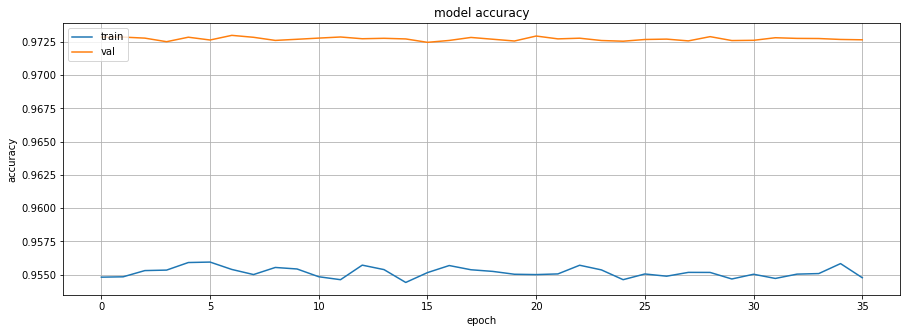

In [ ]:
plt.figure(figsize=(15,5))
plt.grid(True)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

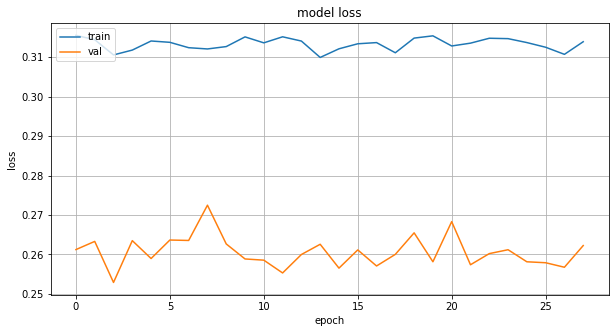

In [ ]:
plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()